here
there
Epoch 1/50
23/23 [==============================] - 3s 60ms/step - loss: 0.0336
Epoch 2/50
23/23 [==============================] - 1s 63ms/step - loss: 0.0033
Epoch 3/50
23/23 [==============================] - 1s 62ms/step - loss: 0.0018
Epoch 4/50
23/23 [==============================] - 1s 61ms/step - loss: 0.0015
Epoch 5/50
23/23 [==============================] - 1s 61ms/step - loss: 0.0013
Epoch 6/50
23/23 [==============================] - 1s 62ms/step - loss: 0.0012
Epoch 7/50
23/23 [==============================] - 2s 65ms/step - loss: 0.0010
Epoch 8/50
23/23 [==============================] - 1s 63ms/step - loss: 9.6376e-04
Epoch 9/50
23/23 [==============================] - 1s 64ms/step - loss: 9.0029e-04
Epoch 10/50
23/23 [==============================] - 1s 63ms/step - loss: 8.4027e-04
Epoch 11/50
23/23 [==============================] - 1s 62ms/step - loss: 7.8137e-04
Epoch 12/50
23/23 [==============================] - 1s 64ms/step - loss: 7.4241e-04
Epoch 

'files=glob.glob("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\harris_county\\smap_2022\\*.csv")\nfiles.sort(key=os.path.getctime)\nltime=[]\nldatetime=[]\ndf=pd.DataFrame()\nfor i in files:\n    dfsmap1 = pd.read_csv(i, sep=",")\n    \n    ltime.append(i.split("\\")[-1].split("_")[1:])\n    namesmap=i.split("\\")[-1].split("_")[1:]\n    namesmapf=(namesmap[0]+\'-\'+namesmap[1]+\'-\'+namesmap[2]).replace(" ", "_")\n    file_name=\'\\\\coastal\\soilmoisture_sitedata\\PNNL\\SMAP\\\'+namesmapf\n    dfsmap1.to_csv(file_name, sep=\',\',index = False)\n    #df[i.split("\\")[-1].split("_")[0]]=dfsmap1[\'SM_m3_m3\']\n    #df_t = dfsmap1.T\nfiles=glob.glob("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\predictedsmap\\*.csv")\nfiles.sort(key=os.path.getctime)\nltime=[]\nldatetime=[]\ndf=pd.DataFrame()\nfor i in files:\n    dfsmap1 = pd.read_csv(i, sep=",")\n    \n    ltime.append(i.split("\\")[-1].split("_")[2:])\n    namesmap=i.split("\\")[-1].split("_")[2:]\n    namesmapf=

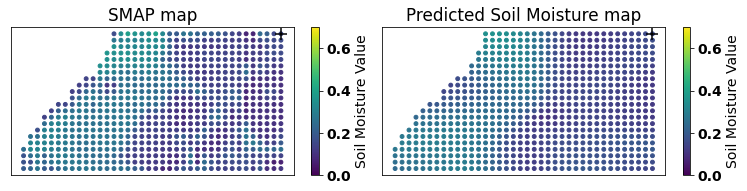

In [172]:
import os
import glob
import math
import folium
import random
import shutil
import warnings
import dateutil

import numpy as np
import pandas as pd
import gstools as gs
import seaborn as sns
import numpy.ma as ma
import tensorflow as tf
import branca.colormap as cm
import pykrige.kriging_tools as kt
import plotly.graph_objects as go

from scipy import spatial
from datetime import datetime
from tensorflow import keras
from matplotlib import pyplot as plt
from pykrige.ok import OrdinaryKriging
from plotly.subplots import make_subplots
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pykrige.kriging_tools import write_asc_grid
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")


def Remove_Outliers(dfsmc,columnname):
    dfsmc[columnname]=dfsmc[columnname].astype(float)
    medianc = dfsmc[columnname].median()
    #std = dfsmc[columnname].std()
    outliers = (dfsmc[columnname] - medianc).abs() > 100
    dfsmc[outliers] = np.nan
    #print(outliers)
    dfsmc[columnname].fillna(medianc, inplace=True)
    return dfsmc[columnname]

def preprocess_TxSON(smfile):
    dfsm = pd.read_csv(smfile, sep=",", header=1)
    dfsm = dfsm.drop(labels=[0,1], axis=0)

    dfsm = dfsm.reset_index(drop=True)

    dfsm['TIMESTAMP']= pd.to_datetime(dfsm['TIMESTAMP'])
    dfsm['TIMESTAMP']=dfsm['TIMESTAMP'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
    dfsm['TIMESTAMP']=pd.to_datetime(dfsm['TIMESTAMP'])
    dfsm['date']=dfsm['TIMESTAMP'].apply(lambda x: int(x.strftime("%Y%m%d")))

    #dfsm['VWC_1_Avg']=dfsm['VWC_1_Avg'].astype(float)
    #dfsm['VWC_2_Avg']=dfsm['VWC_2_Avg'].astype(float)
    #dfsm['VWC_3_Avg']=dfsm['VWC_3_Avg'].astype(float)
    #dfsm['VWC_4_Avg']=dfsm['VWC_4_Avg'].astype(float)
    dfsm=dfsm.dropna()
    dfsm= dfsm.replace(-99,np.nan)
    if 'Rain_mm_Tot' in dfsm.columns:
        dfsm['Rain_mm_Tot']=dfsm['Rain_mm_Tot'].astype(float)
    else:
        dfsm['Rain_mm_Tot']=0
    h=[]
    hvwc=[]
    ht=[]
    if 'EC_1_Avg' in dfsm.columns:
        dfsm['EC_1']=Remove_Outliers(dfsm,'EC_1_Avg')
        #plt.plot(dfsm['EC_1_Avg'].astype(float))
        h.append('EC_1')
        if 'EC_2_Avg' in dfsm.columns:
            dfsm['EC_2_Avg']=Remove_Outliers(dfsm,'EC_2_Avg')
            h.append('EC_2')
        if 'EC_3_Avg' in dfsm.columns:
            dfsm['EC_3']=Remove_Outliers(dfsm,'EC_3_Avg')
            h.append('EC_3')
        if 'EC_4_Avg' in dfsm.columns:
            dfsm['EC_4']=Remove_Outliers(dfsm,'EC_4_Avg')
            h.append('EC_4')
    elif 'ECsoil_1_Avg' in dfsm.columns:
        h.append('EC_1_Avg')
        dfsm['EC_1_Avg']=Remove_Outliers(dfsm,'ECsoil_1_Avg')
        if 'ECsoil_2_Avg' in dfsm.columns:
            dfsm['EC_2']=Remove_Outliers(dfsm,'ECsoil_2_Avg')
            h.append('EC_2')
        if 'ECsoil_3_Avg' in dfsm.columns:
            dfsm['EC_3']=Remove_Outliers(dfsm,'ECsoil_3_Avg')
            h.append('EC_3')
        if 'ECsoil_4_Avg' in dfsm.columns:
            dfsm['EC_4']=Remove_Outliers(dfsm,'ECsoil_4_Avg')
            h.append('EC_4')
    if 'VWC_1_Avg' in dfsm.columns:
        dfsm['VWC_1']=Remove_Outliers(dfsm,'VWC_1_Avg')
        hvwc.append('VWC_1')
        if 'VWC_2_Avg' in dfsm.columns:
            dfsm['VWC_2']=Remove_Outliers(dfsm,'VWC_2_Avg')
            hvwc.append('VWC_2')
        if 'VWC_3_Avg' in dfsm.columns:
            dfsm['VWC_3']=Remove_Outliers(dfsm,'VWC_3_Avg')
            hvwc.append('VWC_3')
        if 'VWC_4_Avg' in dfsm.columns:
            dfsm['VWC_4']=Remove_Outliers(dfsm,'VWC_4_Avg')
            hvwc.append('VWC_4')
    if 'T_1_Avg' in dfsm.columns:
        dfsm['T_1']=dfsm['T_1_Avg'].astype(float)#Remove_Outliers(dfsm,'T_1_Avg')
        ht.append('T_1')
        if 'T_2_Avg' in dfsm.columns:
            dfsm['T_2']=dfsm['T_2_Avg'].astype(float)#Remove_Outliers(dfsm,'T_2_Avg')
            ht.append('T_2')
        if 'T_3_Avg' in dfsm.columns:
            dfsm['T_3']=dfsm['T_3_Avg'].astype(float)#Remove_Outliers(dfsm,'T_3_Avg')
            ht.append('T_3')
        if 'T_4' in dfsm.columns:
            dfsm['T_4']=dfsm['T_4_Avg'].astype(float)#Remove_Outliers(dfsm,'T_4_Avg')
            ht.append('T_4')
    hec=h
    
    
    
    return dfsm,hvwc,ht,hec


def recompose(x):
    U = tf.cast(x, dtype=tf.float32)
    U = U/tf.sqrt(nS-1)
    test_mean = tf.reshape(time_mean[0,:], [1, time_mean[0,:].shape[0]])
    y_hat = (tf.matmul(U, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))) *  tf.sqrt(nS-1) + test_mean
    return y_hat


class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        


        
        
def plot_HCFCD(dfsitesMatrixSM,site_no):
    data=[]


    data.append(go.Scattergl(x = dfsitesMatrixSM["sites_dates"], y = dfsitesMatrixSM[str(site_no)], name='Soil Moisture'))


    # Sub figure 1
    y1 = go.layout.YAxis(title='Soil Moisture', titlefont=dict(color='SteelBlue'),tickfont=dict(color='SteelBlue'))
    layout = go.Layout(yaxis1 = y1)
    sub_fig1 = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02) 


    sub_fig1.add_trace(data[0], row=1, col=1)
    sub_fig1['layout']['yaxis']['title']='Soil Moisture'

    
    sub_fig1.update_traces(connectgaps=False)


    sub_fig1.update_layout(xaxis_range=[dfsitesMatrixSM["sites_dates"].iat[-1] + dateutil.relativedelta.relativedelta(weeks=-1),
                                   dfsitesMatrixSM["sites_dates"].iat[-1]],hovermode='x')
    sub_fig1.update_layout(
        autosize=True,
        height=1000,)
    config = {'displayModeBar': True, "displaylogo": True}
    sub_fig1.update_xaxes(row=1, col=1,rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate")#,
                #dict(count=1, label="1y", step="year", stepmode="backward")
            ])))
    sub_fig1.update_xaxes(rangeslider_visible=True,row=1, col=1,rangeslider_thickness = 0.1)
    sub_fig1.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.06,
        xanchor="right",
        x=1
    ))
    fig_json = sub_fig1.to_json()
    return fig_json



    



def getdelta(lst):
    mn=min(list(lst))
    mx=max(list(lst))
    deltlst=(mx-mn)/15
    return deltlst
def f2hex(val,mn,mx,deltlst):
    color_list=["#00FFFF",
                "#98F5FF",
               "#7FFFD4",
               "#7AC5CD",
               "#76EEC6",
               "#66CDAA",
               "#CAFF70",
               "#A2CD5A",
               "#B4EEB4",
               "#8B8B00",
               "#CDCD00",
               "#EEEE00",
               "#FFFF00",
               "#FF8247",
               "#EE0000"]
    
    if mn<=val<(mn+deltlst):
        clr=color_list[0]
    elif (mn+deltlst)<=val<(mn+2*deltlst):
        clr=color_list[1]
    elif (mn+2*deltlst)<=val<(mn+3*deltlst):
        clr=color_list[2]
    elif (mn+3*deltlst)<=val<(mn+4*deltlst):
        clr=color_list[3]
    elif (mn+4*deltlst)<=val<(mn+5*deltlst):
        clr=color_list[4]
    elif (mn+5*deltlst)<=val<(mn+6*deltlst):
        clr=color_list[5]
    elif (mn+6*deltlst)<=val<(mn+7*deltlst):
        clr=color_list[6]
    elif (mn+7*deltlst)<=val<(mn+8*deltlst):
        clr=color_list[7]
    elif (mn+8*deltlst)<=val<(mn+9*deltlst):
        clr=color_list[8]
    elif (mn+9*deltlst)<=val<(mn+10*deltlst):
        clr=color_list[9]
    elif (mn+10*deltlst)<=val<(mn+11*deltlst):
        clr=color_list[10]
    elif (mn+11*deltlst)<=val<(mn+12*deltlst):
        clr=color_list[11]
    elif (mn+12*deltlst)<=val<(mn+13*deltlst):
        clr=color_list[12]
    elif (mn+13*deltlst)<=val<(mn+14*deltlst):
        clr=color_list[13]
    elif (mn+14*deltlst)<=val<(mn+15*deltlst):
        clr=color_list[14]
    else:
        clr="#EE0000"

    return clr
        
        
###################################################################        
files=glob.glob("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\harris_county\\smap_2022\\*.csv")
files.sort(key=os.path.getctime)
ltime=[]
ldatetime=[]
df=pd.DataFrame()
for i in files:
    dfsmap1 = pd.read_csv(i, sep=",",usecols=['SM_m3_m3'])
    
    ltime.append(i.split("\\")[-1].split("_")[0])
    ldatetime.append(i.split("\\")[-1].split("_")[1])
    df[i.split("\\")[-1].split("_")[0]]=dfsmap1['SM_m3_m3']
    #df_t = dfsmap1.T
    #print(i)
df_t = df.T

df_t.index = df_t.index.astype(int)
df_t = df_t.sort_index(axis = 0)

#df_tt=df_t.T
#df_tt[1461]=df_tt[1460]+.1*mean(df_tt[1460])
#df_tt[1462]=df_tt[1461]+.1*mean(df_tt[1461])
#df_tt[1463]=df_tt[1462]+.1*mean(df_tt[1462])
#df_tt[1464]=df_tt[1463]+.05*mean(df_tt[1463])
# 4 Days should be added 
dfsites=pd.read_csv("E:\\Soil_Moisture\\TRACER\\harris_county\\sites_info.csv", sep=",")

dfsmaplast=pd.read_csv(i, sep=",")

dfsitesSM=pd.read_csv("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\HCFCD_latest_SM.txt", sep=",",names=['site_id','SM'])
dfsitesdiffSM=pd.read_csv("diffHCFCD_latest_SM.txt", sep=",",names=['site_id','diffSM'])
dfsitesMatrixSM=pd.read_csv("matrix_HCFCD_latest_SM.txt", sep=",",
                                names=['1','2','3','4','5','6','7','8','9','10','11',
                                       '12','13','14','15','16','17','18','19','20','21','22','23','24','25'])
print('here')


dfsitesdatesSM=pd.read_csv("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\dates_HCFCD_latest_SM.txt", sep=",",
                                names=['sites_dates'])


print('there')

dfsitesdiffMatrixSM=pd.read_csv("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\diff_matrix_HCFCD_latest_SM.txt", sep=",",
                                names=['1','2','3','4','5','6','7','8','9','10','11',
                                       '12','13','14','15','16','17','18','19','20','21','22','23','24','25'])

smfile='\\\coastal\\soilmoisture_sitedata\\raw_data\\CR300_17_TRACER1_SubHourly_soil.dat'
dfsm17,hvwc,ht,hec=preprocess_TxSON(smfile)

smfile='\\\coastal\\soilmoisture_sitedata\\raw_data\\CR300_18_TRACER2_SubHourly_soil.dat'
dfsm18,hvwc,ht,hec=preprocess_TxSON(smfile)
smfile='\\\coastal\\soilmoisture_sitedata\\raw_data\\CR300_19_TRACER3_SubHourly_soil.dat'
dfsm19,hvwc,ht,hec=preprocess_TxSON(smfile)

smfile='\\\coastal\\soilmoisture_sitedata\\raw_data\\CR300_20_TRACER4_SubHourly_soil.dat'
dfsm20,hvwc,ht,hec=preprocess_TxSON(smfile)


date_string = ldatetime[-1]
datetime.fromisoformat(date_string)
now = datetime.now()
n_missingSMAP=math.floor((now-datetime.fromisoformat(date_string)).total_seconds()/(60*60*6))
n_lastSMAP=int(ltime[-1])
n_lastSMAP=1520
date_stringi=date_string
datetimeslist_for_Presiction=[]
n_missingSMAP=10
for imsmp in range(0, n_missingSMAP):
    datetimeslist_for_Presiction.append(datetime.fromisoformat(date_stringi)+timedelta(hours=6*(1+imsmp)))
############################# LSTM ####################################################

# Define the number of future rows to forecast (20 rows)
forecast_rows = 50

# Define the number of previous rows to use for prediction
look_back = 50  # Adjust as needed

# Load dfsitesMatrixSM and df_t data
dfsitesMatrixSMn = dfsitesMatrixSM.iloc[0:1530, : 25]
df_tn = df_t[:][0:1520].copy()

# Extract the numerical values
guiding_data = dfsitesMatrixSMn.values
target_data = df_tn.values

# Create input sequences and targets
X, y = [], []

# Iterate through the guiding data to create sequences
for i in range(len(target_data) - look_back - forecast_rows):
    X.append(guiding_data[i:(i+look_back)])
    y.append(target_data[i+look_back:i+look_back+forecast_rows])

X_input, y_target = np.array(X), np.array(y)

# Build a multi-output LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, guiding_data.shape[1]), return_sequences=True))
model.add(Dense(target_data.shape[1]))  # Update the output layer

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
model.fit(X_input, y_target, epochs=50, batch_size=64)  # Adjust epochs and batch size as needed

# Make predictions for the missing 20 rows
last_guiding_data = guiding_data[-look_back:]
input_sequence = last_guiding_data.reshape(1, look_back, guiding_data.shape[1])
forecast = model.predict(input_sequence)

for imsmp in range(0, n_missingSMAP):
    df_t.loc[len(df_t)+1]=list(forecast[0][imsmp])


######################################################## Spatiotemporal############################
df_tt = df_t.T.copy()
print(len(df_tt))
reconstructed=tf.convert_to_tensor(df_tt)
latlon = pd.read_csv('E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\Houston_Lat_Long.csv', sep=',', names=['X','Y'])
coords = latlon[['X', 'Y']]
field=reconstructed
field_coords=coords
train_n = 700 # we will later split into training and validation
test_n = 1

X_train = coords.iloc[:train_n, :]
X_test = coords.iloc[train_n:train_n+test_n,:]
y_train = reconstructed[:train_n, :]
y_test = reconstructed[train_n:train_n+test_n,:]
Z = tf.cast(y_train, tf.float32) 

time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend

# Using tf.linalg.svd to calculate the singular value decomposition 
s, u, v = tf.linalg.svd(Ztilde)
u =  u * tf.sqrt(nS-1)
# To recompose 
n_eofs =3
tf_Z_approx = tf.matmul((u[:,:n_eofs]/tf.sqrt(nS-1)), tf.matmul(tf.linalg.diag(s[:n_eofs]), v[:,:n_eofs], adjoint_b=True))


reconstructed = tf_Z_approx * tf.sqrt(nS-1) + time_mean

###########################


############################
check = reconstructed - Z
train_val_split = 600
n_eofs = 3
X_train, X_valid = X_train.values[:train_val_split,:], X_train.values[train_val_split:,:]
u_train, u_valid = u[:train_val_split,:n_eofs], u[train_val_split:,:n_eofs]
s = s[:n_eofs]
v = v[:,:n_eofs]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
X_mesh = scaler.transform(field_coords)



input_A = keras.layers.Input(shape=[2,]) # The input are the geographical variables X, Y, Z
hidden_1 = keras.layers.Dense(300, activation="elu",
                              kernel_initializer="he_normal")(input_A)
hidden_2 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_1)
hidden_3 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_2)
hidden_4 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_3)
hidden_5 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_4)
aux_output = keras.layers.Dense(n_eofs)(hidden_5)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y




K = keras.backend

batch_size = 32     
n_epochs = 2000
patience = 500
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True) 


model = keras.Model(inputs=[input_A], outputs=[output, aux_output])
model.compile(loss=['mae', 'mae'], loss_weights=[1.0,0.0], optimizer='nadam')

history = model.fit([X_train], [y_train[:train_val_split,:], u_train], epochs=n_epochs,
                    validation_data=([X_valid], [y_train[train_val_split:,:], u_valid]),
                   callbacks=[early_stopping_cb, onecycle], verbose=0) 

y_hat_test, y_pred_test = model.predict([X_test])
y_hat_mesh, y_pred_mesh = model.predict([X_mesh])


mae = np.zeros(y_test.shape[1])
for i in range(y_test.shape[1]):
    mae[i] = MAE(y_test[:,i], y_hat_test[:,i])
    
mae_spatial =  np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    mae_spatial[i] = MAE(y_test[i,:], y_hat_test[i,:])



seed = np.random.seed(seed=12345)
test_coords = coords.iloc[train_n:train_n+test_n,:]
loc = 0#np.random.randint(0, test_coords.shape[0])
loc_x = test_coords['X'].iloc[loc]
loc_y = test_coords['Y'].iloc[loc]
#timestamp = np.random.randint(0, mae.shape[0])
timestamp = 40
plt.figure(figsize=(13,6))
plt.subplots_adjust(wspace = 0.05)
plt.subplot(2,2,1)
plt.scatter( field_coords['Y'],field_coords['X'],c= field[:,770], s = 15,  vmin=0.0, vmax=.7)
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Soil Moisture Value')
plt.scatter(loc_x, loc_y, c ='black', marker='+', s=150)
plt.title('SMAP map')
plt.subplot(2,2,2)
plt.scatter(field_coords['Y'], field_coords['X'], c= y_hat_mesh[:,770], s = 15,  vmin=.0, vmax=.7)
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Soil Moisture Value')
plt.scatter(loc_x, loc_y, c ='black', marker='+', s=150)
plt.title('Predicted Soil Moisture map')

latlon = pd.read_csv('E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\Houston_Lat_Long.csv', sep=',', names=['X','Y'])

lcord=np.array([[i,j] for i,j in zip(latlon['X'],latlon['Y'])])
Xsmap_krig=[]
Ysmap_krig=[]
SM_krig=[]
for i in lcord:
    Xsmap_krig.append(i[0])
    Ysmap_krig.append(i[1])


predictedsmapfilenames=[]
for i in range(0,4):#range(0,len(datetimeslist_for_Presiction))
    predicted_SM_df=pd.DataFrame();
    predicted_SM_df['x']=Ysmap_krig
    predicted_SM_df['y']=Xsmap_krig
    ipredicted=int(ltime[-7])+i
    predicted_SM_df['SM_m3_m3']=field[:,ipredicted-1]
    pathpredictedsmap="E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\predictedsmap\\"
    namepredictedfile=pathpredictedsmap+"P_"+str(ipredicted)+"_"+datetimeslist_for_Presiction[i].strftime("%Y-%m-%d %H_%M_%S")+".csv"
    predicted_SM_df.to_csv(namepredictedfile, sep=',')
    predictedsmapfilenames.append(namepredictedfile)
    

dfsitesdatesSM['sites_dates']=dfsitesdatesSM['sites_dates'].astype('datetime64[ns]')
dfsitesMatrixSM['sites_dates']=dfsitesdatesSM['sites_dates']

#!python -m http.server

n1=0
n2=1
n3=5
n4=6
with open('E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\Houston_Lat_Long.csv') as f:
    latlon = [tuple(map(float, i.split(','))) for i in f]
#latlon = coordsf#[ (51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.13878830247011467), (51.249768239976866, -2.8610415615063034)]
mapit = folium.Map( location=[25.949565656565657, -97.47994545454546], zoom_start=6 )
delLat=0.07060000000000244/2#(latlon[n3][0]-latlon[n1][0])/2
delLon=0.09340000000000259/2#(latlon[n2][1]-latlon[n1][1])/2
colors_list=['#ff0a00',
 '#ff0a00',
 '#ff1500',
 '#ff1f00',
 '#ff2900',
 '#ff3400',
 '#ff3e00',
 '#ff4800',
 '#ff5200',
 '#ff5d00',
 '#ff6700',
 '#ff7100',
 '#ff7c00',
 '#ff8600',
 '#ff9000',
 '#ff9b00',
 '#ff9b00',
 '#ffaf00',
 '#ffb900',
 '#ffc400',
 '#ffce00',
 '#ffd800',
 '#ffe300',
 '#ffed00',
 '#fff700',
 '#fcff00',
 '#f2ff00',
 '#e8ff00',
 '#deff00',
 '#d3ff00',
 '#c9ff00',
 '#bfff00',
 '#b4ff00',
 '#b4ff00',
 '#a0ff00',
 '#95ff00',
 '#8bff00',
 '#81ff00',
 '#76ff00',
 '#6cff00',
 '#62ff00',
 '#58ff00',
 '#4dff00',
 '#43ff00',
 '#39ff00',
 '#2eff00',
 '#24ff00',
 '#1aff00',
 '#0fff00',
 '#05ff00',
 '#00ff05',
 '#00ff0f',
 '#00ff1a',
 '#00ff24',
 '#00ff2e',
 '#00ff39',
 '#00ff43',
 '#00ff4d',
 '#00ff58',
 '#00ff62',
 '#00ff6c',
 '#00ff76',
 '#00ff81',
 '#00ff8b',
 '#00ff95',
 '#00ffa0',
 '#00ffa0',
 '#00ffb4',
 '#00ffbf',
 '#00ffc9',
 '#00ffd3',
 '#00ffde',
 '#00ffe8',
 '#00fff2',
 '#00fffc',
 '#00f7ff',
 '#00edff',
 '#00e3ff',
 '#00d8ff',
 '#00ceff',
 '#00c4ff',
 '#00b9ff',
 '#00afff',
 '#00a5ff',
 '#009bff',
 '#0090ff',
 '#0086ff',
 '#007cff',
 '#0071ff',
 '#0067ff',
 '#005dff',
 '#0052ff',
 '#0048ff',
 '#003eff',
 '#0034ff',
 '#0029ff',
 '#001fff',
 '#0015ff',
 '#000aff',
 '#000aff']

df = pd.read_csv('E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\TRACER_stations.txt', sep=',')#pandas.read_excel(open('E:\Soil_Moisture\Codes\website\stations\\txsonstations1.xlsx','rb'))


latitude_list2 = df[df['Owner']=='TxSON'].LAT
longitude_list2 = df[df['Owner']=='TxSON'].LON
titles_list2= df[df['Owner']=='TxSON'].logger_ID
files_list2= df[df['Owner']=='TxSON'].files


latitude_list2 = df.LAT
longitude_list2 = df.LON
titles_list2= df.logger_ID
files_list2= df.files

points2= list(zip(latitude_list2.astype('float64'), longitude_list2.astype('float64'))) 

points1= list(zip([29.322142], [-95.745285])) 
base_map = folium.Map(location=[29.972595,-95.435011], control_scale=True, zoom_start=8)

'''train_group = folium.FeatureGroup(name="New Station").add_to(base_map)

for tuple_ in points1:

    icon=folium.Icon(color='red', icon_color="red", prefix='fa')
    train_group.add_child(folium.Marker(tuple_, icon=icon, popup="<i> Guy, Tx station"))'''

cars_group = folium.FeatureGroup(name="TRACER").add_to(base_map)

i_texon=0
for tuple_, title, filef in zip(points2,titles_list2,files_list2):
    sepf=filef.split('\\')[-1].split('_')
    station_name=df['folders'][i_texon]#'_'.join(sepf[0:2])
    #urlec="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/plot_EC.html"
    urlSMP="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/SM_P_Plot.html"
    #urlp="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/plot_precipitation.html"
    #urlvwc="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/plot_VWC.html"
    urlt="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/ST_P_Plot.html"
    html=f""" 
    <h1> Station Name: {title}</h1>
    <p>Click on the property to see the graph:</p>
    <ul>
        <li><a target="_blank" rel="noopener noreferrer" href={urlSMP} >Soil Moisture and Precipitation</a> </li>
        <li><a target="_blank" rel="noopener noreferrer" href={urlt}>Soil Temperature and Precipitation</a> </li>
    </ul>
    </p>
    <p></p></p>
    """
    iframe = folium.IFrame(html=html, width=400, height=200)
    popup = folium.Popup(iframe, max_width=2650)
    icon=folium.Icon(color="orange", icon_color="orange", prefix='fa')
    #cars_group.get_root().html.add_child(JavascriptLink('js.js'))

    cars_group.add_child(folium.Marker(tuple_, icon=icon , popup=popup,tooltip=str(station_name)))
    i_texon=i_texon+1
# Add tiles
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Satellite',
        overlay = False,
        control = True
       ).add_to(base_map)  
folium.TileLayer('stamentoner').add_to(base_map)
folium.TileLayer('stamenwatercolor').add_to(base_map)
folium.TileLayer('cartodbpositron').add_to(base_map)
folium.TileLayer('openstreetmap').add_to(base_map)
folium.TileLayer('stamenterrain').add_to(base_map)

# Add the option to switch tiles
#folium.LayerControl().add_to(base_map)
dfsmap = pd.read_csv(predictedsmapfilenames[0], sep=",")
mn=min(list(dfsmap['SM_m3_m3']))
mx=max(list(dfsmap['SM_m3_m3']))
deltlst=(mx-mn)/100
cmindx=list(np.linspace(mn, mx, 100))
colormap = cm.LinearColormap(colors=colors_list,
                             index=cmindx, vmin=mn, vmax=mx,
                             caption='Soil Moisture[m^3/m^3]')

base_map.add_child(colormap)


dfsites=pd.read_csv("E:\\Soil_Moisture\\TRACER\\harris_county\\sites_info.csv", sep=",")
pointsHCFCD= list(zip(dfsites.Lat, dfsites.Long)) 
cars_group2 = folium.FeatureGroup(name="HCFCD").add_to(base_map)
titles_listHCFCD=dfsites['Contrail ID']
i_HCFCD=0
for tuple_, title in zip(pointsHCFCD,titles_listHCFCD):
    #sepf=filef.split('\\')[-1].split('_')
    station_name=title#'_'.join(sepf[0:2])
    #urlec="https://coastal.beg.utexas.edu/soilmoisture2/data/"+station_name+"/plot_EC.html"
    siteno=i_HCFCD+1
    fig_json=plot_HCFCD(dfsitesMatrixSM,siteno)
    patht="//coastal/web_applications/soilmoisture2/data/HCFCD/HCFCD_Plot_"+str(siteno)+".html"
    templatet = """<html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <a href ="https://coastal.beg.utexas.edu/soilmoisture2/TRACER_SM_P.html">Back</a>
    <body>
        <div id='divPlotly'></div>
        <script>
            var plotly_data = {}
            Plotly.react('divPlotly', plotly_data.data, plotly_data.layout);
        </script>
    </body>

    </html>"""
    with open(patht, 'w') as f:
        f.write(templatet.format(fig_json))
    urlt="https://coastal.beg.utexas.edu/soilmoisture2/data/HCFCD/HCFCD_Plot_"+str(siteno)+".html"
    html=f""" 
    <h1> Station Name: {title}</h1>
        <p>Click on the property to see the graph:</p>
    <ul>
        <li><a target="_blank" rel="noopener noreferrer" href={urlt} >Soil Moisture</a> </li>
    </ul>
    </p>
    <p></p></p>
    
    """
    iframe = folium.IFrame(html=html, width=400, height=200)
    popup = folium.Popup(iframe, max_width=2650)
    icon=folium.Icon(color="blue", icon_color="blue", prefix='fa')
    #cars_group.get_root().html.add_child(JavascriptLink('js.js'))

    cars_group2.add_child(folium.Marker(tuple_, icon=icon , popup=popup,tooltip=str(station_name)))
    i_HCFCD=i_HCFCD+1
    

    
    
dfsmaplast = pd.read_csv(files[-1], sep=",")
shapesLayerlast = folium.FeatureGroup(name="Last SMAP "+(datetimeslist_for_Presiction[0]+timedelta(hours=-6)).strftime("%Y-%m-%d %H_%M_%S"),show=True).add_to(base_map)
ismap=0
for coord in latlon:
    txt=str(round(dfsmap['SM_m3_m3'][ismap],7))
    #folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de' ).add_to( mapit )
    color = colormap(dfsmaplast['SM_m3_m3'][ismap])

    folium.Rectangle(
    [(coord[0]-delLat, coord[1]-delLon), (coord[0]+delLat, coord[1]+delLon)],
    weight=2,
        color=color,#f2hex(dfsmap['SM_m3_m3'][ismap],mn,mx,deltlst),
    opacity=0.0,
    fill_color=color,#f2hex(dfsmap['SM_m3_m3'][ismap],mn,mx,deltlst),
    popup=(folium.Popup(txt)),fill_opacity=0.4).add_to(shapesLayerlast)
    ismap=ismap+1    

for ilayer in range(0,len(predictedsmapfilenames)):
    dfsmap = pd.read_csv(predictedsmapfilenames[ilayer], sep=",")
    mn=min(list(dfsmap['SM_m3_m3']))
    mx=max(list(dfsmap['SM_m3_m3']))
    deltlst=(mx-mn)/100
    cmindx=list(np.linspace(mn, mx, 100))
    colormap = cm.LinearColormap(colors=colors_list,
                                 index=cmindx, vmin=mn, vmax=mx,
                                 caption='Soil Moisture[m^3/m^3]')

    shapesLayer = folium.FeatureGroup(name="Predicted SMAP "+datetimeslist_for_Presiction[ilayer].strftime("%Y-%m-%d %H_%M_%S"),show=False).add_to(base_map)
    ismap=0
    for coord in latlon:
        txt=str(round(dfsmap['SM_m3_m3'][ismap],7))
        #folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de' ).add_to( mapit )
        color = colormap(dfsmap['SM_m3_m3'][ismap])

        folium.Rectangle(
        [(coord[0]-delLat, coord[1]-delLon), (coord[0]+delLat, coord[1]+delLon)],
        weight=2,
            color=color,#f2hex(dfsmap['SM_m3_m3'][ismap],mn,mx,deltlst),
        opacity=0.0,
        fill_color=color,#f2hex(dfsmap['SM_m3_m3'][ismap],mn,mx,deltlst),
        popup=(folium.Popup(txt)),fill_opacity=0.4).add_to(shapesLayer)
        ismap=ismap+1
folium.LayerControl().add_to(base_map)


base_map.save('//coastal/web_applications/soilmoisture2/TRACER_SM_P.html')
base_map

'''files=glob.glob("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\harris_county\\smap_2022\\*.csv")
files.sort(key=os.path.getctime)
ltime=[]
ldatetime=[]
df=pd.DataFrame()
for i in files:
    dfsmap1 = pd.read_csv(i, sep=",")
    
    ltime.append(i.split("\\")[-1].split("_")[1:])
    namesmap=i.split("\\")[-1].split("_")[1:]
    namesmapf=(namesmap[0]+'-'+namesmap[1]+'-'+namesmap[2]).replace(" ", "_")
    file_name='\\\coastal\\soilmoisture_sitedata\\PNNL\\SMAP\\'+namesmapf
    dfsmap1.to_csv(file_name, sep=',',index = False)
    #df[i.split("\\")[-1].split("_")[0]]=dfsmap1['SM_m3_m3']
    #df_t = dfsmap1.T
files=glob.glob("E:\\Soil_Moisture\\Codes\\website\\code\\final_version\\predictedsmap\\*.csv")
files.sort(key=os.path.getctime)
ltime=[]
ldatetime=[]
df=pd.DataFrame()
for i in files:
    dfsmap1 = pd.read_csv(i, sep=",")
    
    ltime.append(i.split("\\")[-1].split("_")[2:])
    namesmap=i.split("\\")[-1].split("_")[2:]
    namesmapf=(namesmap[0]+'-'+namesmap[1]+'-'+namesmap[2]).replace(" ", "_")
    file_name='\\\coastal\\soilmoisture_sitedata\\PNNL\\Predicted_SMAP\\'+namesmapf
    dfsmap1.to_csv(file_name, sep=',',index = False)
    #df[i.split("\\")[-1].split("_")[0]]=dfsmap1['SM_m3_m3']
    #df_t = dfsmap1.T'''

Text(0.5, 1.0, 'Predicted Soil Moisture map')

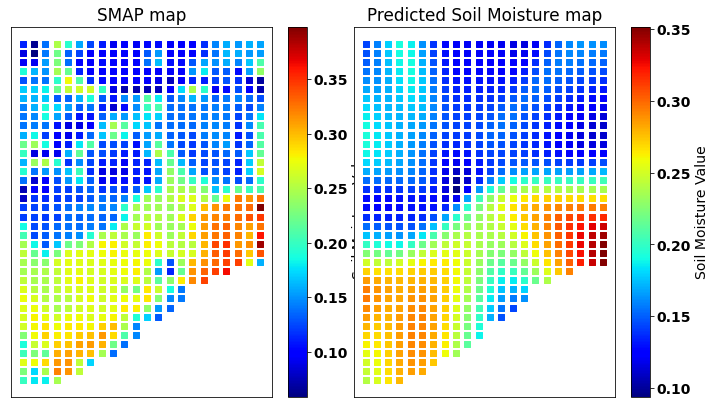

In [211]:
seed = np.random.seed(seed=12345)
test_coords = coords.iloc[train_n:train_n+test_n,:]
loc = 0#np.random.randint(0, test_coords.shape[0])
loc_x = test_coords['X'].iloc[loc]
loc_y = test_coords['Y'].iloc[loc]
#timestamp = np.random.randint(0, mae.shape[0])
timestamp = 40
plt.figure(figsize=(12,15))
plt.subplots_adjust(wspace = 0.05)
plt.subplot(2,2,1)
plt.scatter( field_coords['Y'],field_coords['X'],c= field[:,770], marker='s',cmap='jet')
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Soil Moisture Value')
plt.title('SMAP map')
plt.subplot(2,2,2)
plt.scatter(field_coords['Y'], field_coords['X'], c= y_hat_mesh[:,770], marker='s',cmap='jet')
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Soil Moisture Value')
plt.title('Predicted Soil Moisture map')

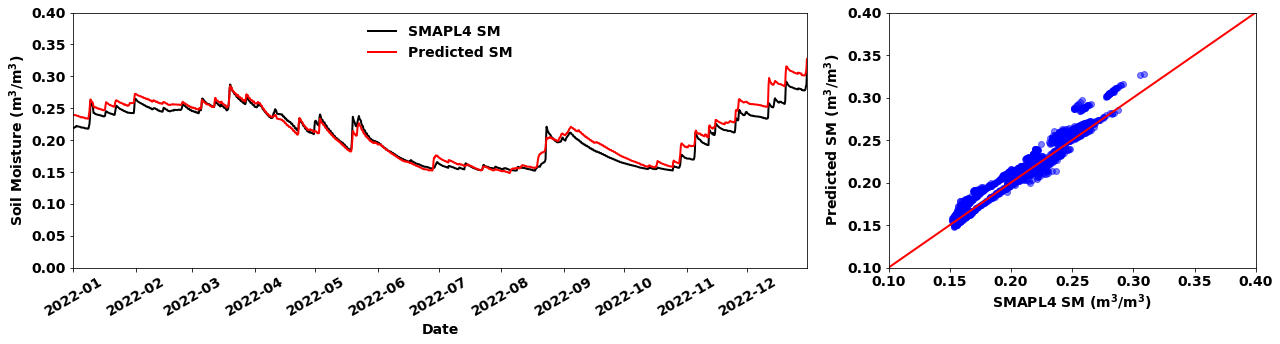

In [203]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Subplot 1 (Twice the length)
plt.subplot(gs[0])
plt.plot(dfsitesdatesSM['sites_dates'][:1456], y_test[0, :1456], label='SMAPL4 SM', color='black', linewidth=2)
plt.plot(dfsitesdatesSM['sites_dates'][:1456], y_hat_test[0, :1456], label='Predicted SM', color='red', linewidth=2)
plt.ylabel('Soil Moisture ($\mathregular{m^3/m^3}$)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.xlim(dfsitesdatesSM['sites_dates'][0], dfsitesdatesSM['sites_dates'][1455])
plt.ylim([0, 0.4])
plt.xticks(rotation=30)
plt.legend(loc='upper center', frameon=False)

# Subplot 2
plt.subplot(gs[1])
plt.scatter(y_test[0, :1456], y_hat_test[0, :1456], color='blue', alpha=0.5)
plt.plot([0.1, 0.4], [0.1, 0.4], color='red', linewidth=2)
plt.ylabel('Predicted SM ($\mathregular{m^3/m^3}$)', fontsize=14, fontweight='bold')
plt.xlabel('SMAPL4 SM ($\mathregular{m^3/m^3}$)', fontsize=14, fontweight='bold')
plt.ylim([0.1, 0.4])
plt.xlim([0.1, 0.4])

# Create an empty subplot to fill the space (Subplot 3)
plt.subplot(gs[1])

plt.tight_layout()
plt.show()

19/19 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Soil Moisture ($\\mathregular{m^3/m^3}$)')

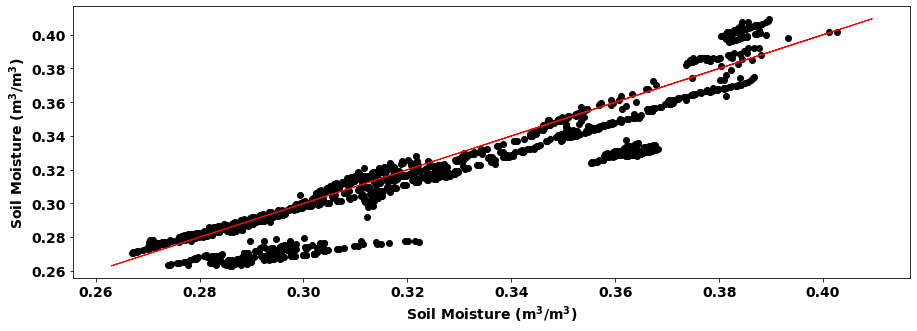

In [188]:
plt.figure(figsize=(15,5))
y_hat_train, y_pred_train = model.predict([X_train]) 
plt.scatter(y_hat_train[10,:1456],y_train[10,:1456], color = 'black')
plt.plot(y_train[10,:1456],y_train[10,:1456], color = 'red', linewidth = 1)

#plt.plot(dfsitesdatesSM['sites_dates'][:1456], y_hat_test[0,:1456], label='Predicted SM', color = 'red', linewidth = 2)
plt.ylabel('Soil Moisture ($\mathregular{m^3/m^3}$)',fontsize= 14, fontweight='bold')
plt.xlabel('Soil Moisture ($\mathregular{m^3/m^3}$)',fontsize= 14, fontweight='bold')
#plt.xlim(dfsitesdatesSM['sites_dates'][0], dfsitesdatesSM['sites_dates'][1455])
#plt.ylim([0,0.4])
#plt.xticks(rotation=30)
#plt.legend(loc='upper center', frameon=False)

Text(0.5, 0, 'No of Components')

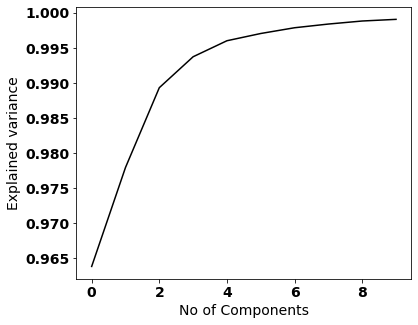

In [125]:
X_train = coords.iloc[:train_n, :]
X_test = coords.iloc[train_n:train_n+test_n,:]
y_train = reconstructed[:train_n, :]
y_test = reconstructed[train_n:train_n+test_n,:]
Z = tf.cast(y_train, tf.float32) 

time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend

s, u, v = tf.linalg.svd(Ztilde)
u =  u * tf.sqrt(nS-1)
n_eofs =9
plt.figure(figsize=(6,5))
plt.plot((np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s))))[:10], c='black')
plt.ylabel('Explained variance')
plt.xlabel('No of Components')


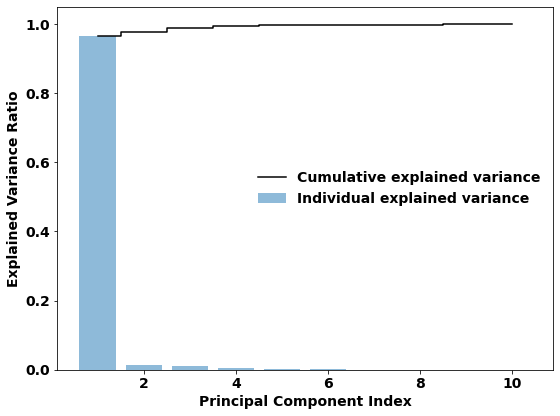

In [126]:
plt.figure(figsize=(8,6))
#https://vitalflux.com/pca-explained-variance-concept-python-example/
cum_sum_eigenvalues = (np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s))))
exp_var_pca = tf.math.square(s)/tf.reduce_sum(tf.math.square(s))
plt.bar(range(1,len(exp_var_pca[0:11])), exp_var_pca[0:10], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues[0:11])), cum_sum_eigenvalues[0:10], c='black',where='mid',label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio',fontsize= 14, fontweight='bold')
plt.xlabel('Principal Component Index',fontsize= 14, fontweight='bold')
plt.legend(loc='right', frameon=False)
plt.tight_layout()
plt.show()

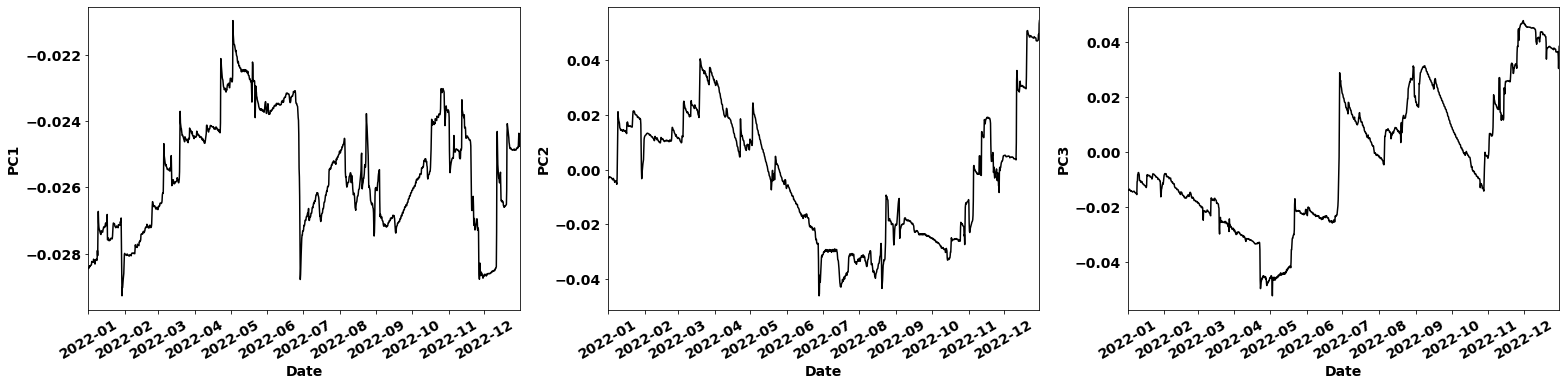

In [127]:
plt.figure(figsize=(22,10))
plt.subplot(2,3,1)
plt.plot(dfsitesdatesSM['sites_dates'][:1456], v[:1456,0], color='black')
plt.xlabel('Date',fontsize= 14, fontweight='bold')
plt.ylabel('PC1',fontsize= 14, fontweight='bold')
plt.xlim(dfsitesdatesSM['sites_dates'][0], dfsitesdatesSM['sites_dates'][1455])
plt.xticks(rotation=30)

plt.subplot(2,3,2)
plt.plot(dfsitesdatesSM['sites_dates'][:1456], v[:1456,1], color='black')
plt.xlabel('Date',fontsize= 14, fontweight='bold')
plt.ylabel('PC2',fontsize= 14, fontweight='bold')
plt.xlim(dfsitesdatesSM['sites_dates'][0], dfsitesdatesSM['sites_dates'][1455])
plt.xticks(rotation=30)

plt.subplot(2,3,3)
plt.plot(dfsitesdatesSM['sites_dates'][:1456], v[:1456,2], color='black')
plt.xlabel('Date',fontsize= 14, fontweight='bold')
plt.ylabel('PC3',fontsize= 14, fontweight='bold')
plt.xlim(dfsitesdatesSM['sites_dates'][0], dfsitesdatesSM['sites_dates'][1455])
plt.xticks(rotation=30)
plt.tight_layout()

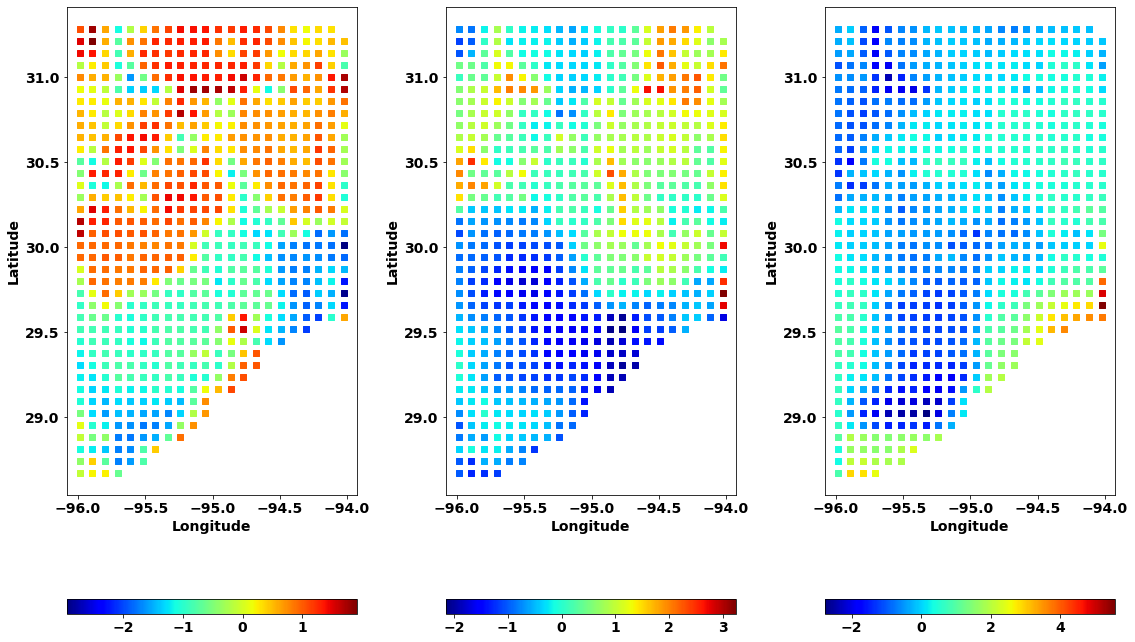

In [128]:
plt.figure(figsize=(16,20))

plt.subplot(2,3,4)
plt.scatter(X_train['Y'],X_train['X'], c=u[:,0], marker='s',cmap='jet')
plt.colorbar(orientation='horizontal')
plt.xlabel('Longitude',fontsize= 14, fontweight='bold')
plt.ylabel('Latitude',fontsize= 14, fontweight='bold')
plt.subplot(2,3,5)
plt.scatter( X_train['Y'],X_train['X'],c=u[:,1], marker='s',cmap='jet')
plt.colorbar(orientation='horizontal')
plt.xlabel('Longitude',fontsize= 14, fontweight='bold')
plt.ylabel('Latitude',fontsize= 14, fontweight='bold')
plt.subplot(2,3,6)
plt.scatter(X_train['Y'],X_train['X'], c=u[:,2], marker='s',cmap='jet')
plt.colorbar(orientation='horizontal')
plt.xlabel('Longitude',fontsize= 14, fontweight='bold')
plt.ylabel('Latitude',fontsize= 14, fontweight='bold')
plt.tight_layout()

In [204]:
dfsmap1

,SM_m3_m3
0,0.282870
1,0.307872
2,0.369962
3,0.297563
4,0.276850
...,...
696,0.194063
697,0.413053
698,0.371693
699,0.302189


In [207]:
latlon

[(28.6704632932119, -95.9867),
 (28.7410632932119, -95.9867),
 (28.8116632932119, -95.9867),
 (28.8822632932119, -95.9867),
 (28.9528632932119, -95.9867),
 (29.0234632932119, -95.9867),
 (29.0940632932119, -95.9867),
 (29.1646632932119, -95.9867),
 (29.2352632932119, -95.9867),
 (29.3058632932119, -95.9867),
 (29.3764632932119, -95.9867),
 (29.4470632932119, -95.9867),
 (29.5176632932119, -95.9867),
 (29.5882632932119, -95.9867),
 (29.6588632932119, -95.9867),
 (29.7294632932119, -95.9867),
 (29.8000632932119, -95.9867),
 (29.8706632932119, -95.9867),
 (29.9412632932119, -95.9867),
 (30.0118632932119, -95.9867),
 (30.0824632932119, -95.9867),
 (30.1530632932119, -95.9867),
 (30.2236632932119, -95.9867),
 (30.2942632932119, -95.9867),
 (30.3648632932119, -95.9867),
 (30.4354632932119, -95.9867),
 (30.5060632932119, -95.9867),
 (30.5766632932119, -95.9867),
 (30.6472632932119, -95.9867),
 (30.7178632932119, -95.9867),
 (30.7884632932119, -95.9867),
 (30.8590632932119, -95.9867),
 (30.929